In [325]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

from feature_engine import encoding
from feature_engine import pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier

In [153]:
import warnings

warnings.filterwarnings("ignore")

In [154]:
df_weather = pd.read_csv('..\\dados\\weather_classification_data.csv')

df_weather

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
13195,10.0,74,14.5,71.0,overcast,1003.15,1,Summer,1.0,mountain,Rainy
13196,-1.0,76,3.5,23.0,cloudy,1067.23,1,Winter,6.0,coastal,Snowy
13197,30.0,77,5.5,28.0,overcast,1012.69,3,Autumn,9.0,coastal,Cloudy
13198,3.0,76,10.0,94.0,overcast,984.27,0,Winter,2.0,inland,Snowy


In [155]:
df_weather['Weather Type'].value_counts()

Weather Type
Rainy     3300
Cloudy    3300
Sunny     3300
Snowy     3300
Name: count, dtype: int64

## Analise

In [156]:
df_weather.dtypes

Temperature             float64
Humidity                  int64
Wind Speed              float64
Precipitation (%)       float64
Cloud Cover              object
Atmospheric Pressure    float64
UV Index                  int64
Season                   object
Visibility (km)         float64
Location                 object
Weather Type             object
dtype: object

In [157]:
df_weather.drop(columns=['Cloud Cover', 'Season', 'Location', 'Weather Type']).describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,13200.0,19.127576,17.386327,-25.00,4.0,21.00,31.0000,109.00
Humidity,13200.0,68.710833,20.194248,20.00,57.0,70.00,84.0000,109.00
Wind Speed,13200.0,9.832197,6.908704,0.00,5.0,9.00,13.5000,48.50
Precipitation (%),13200.0,53.644394,31.946541,0.00,19.0,58.00,82.0000,109.00
Atmospheric Pressure,13200.0,1005.827896,37.199589,800.12,994.8,1007.65,1016.7725,1199.21
UV Index,13200.0,4.005758,3.856600,0.00,1.0,3.00,7.0000,14.00
Visibility (km),13200.0,5.462917,3.371499,0.00,3.0,5.00,7.5000,20.00


## Graficos

### Matriz de correlação

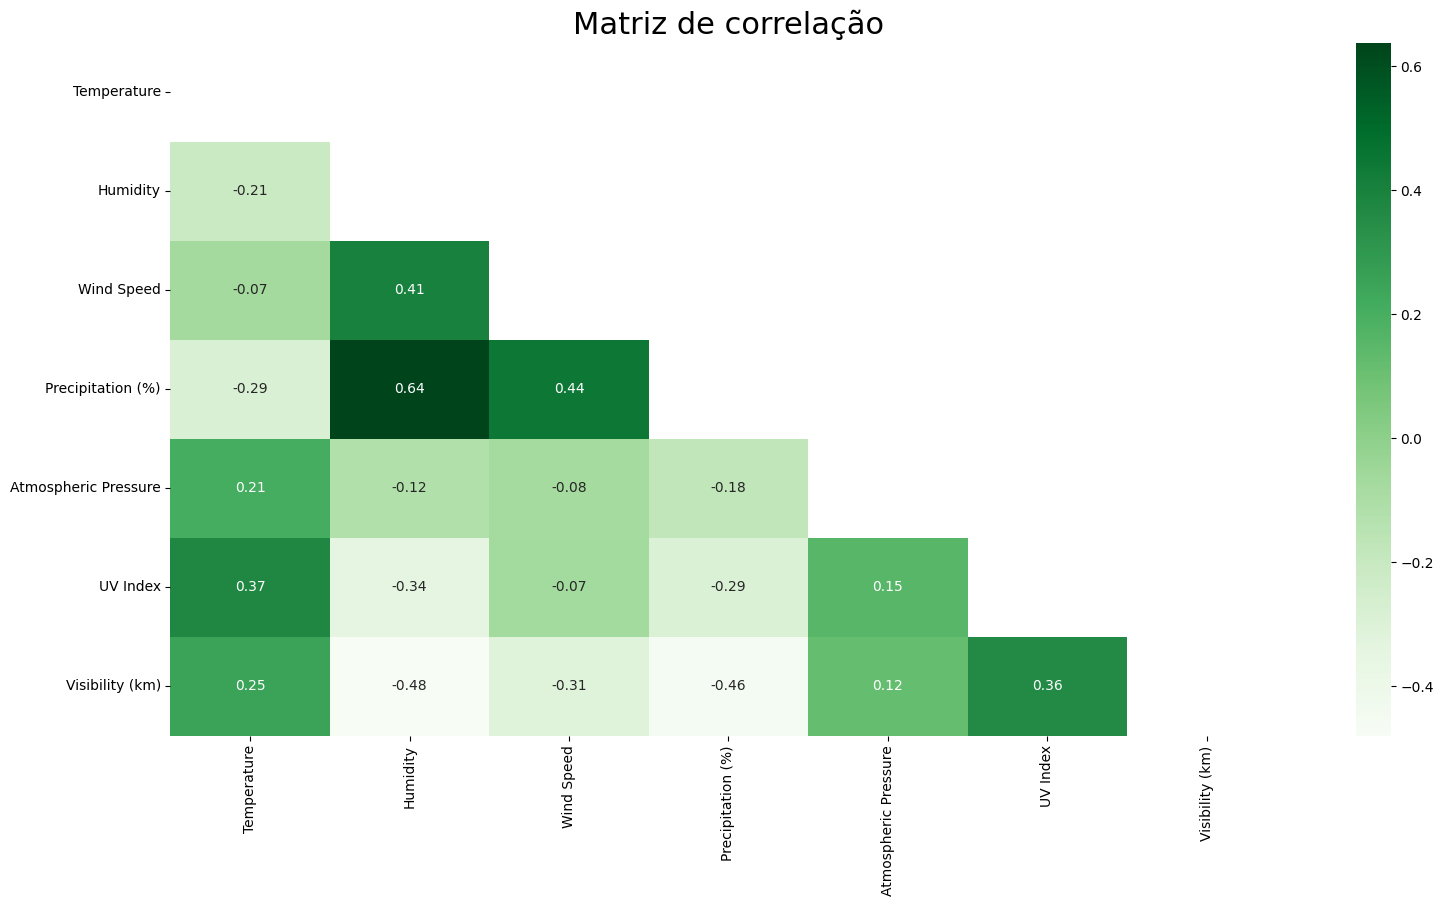

In [158]:
corr = df_weather[df_weather.drop(columns=['Cloud Cover', 'Season', 'Location', 'Weather Type']).columns.tolist()].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
ax = sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='Greens')
ax.set_title('Matriz de correlação', fontsize=22)
ax.figure.set_size_inches(18, 9)

### Hitogramas

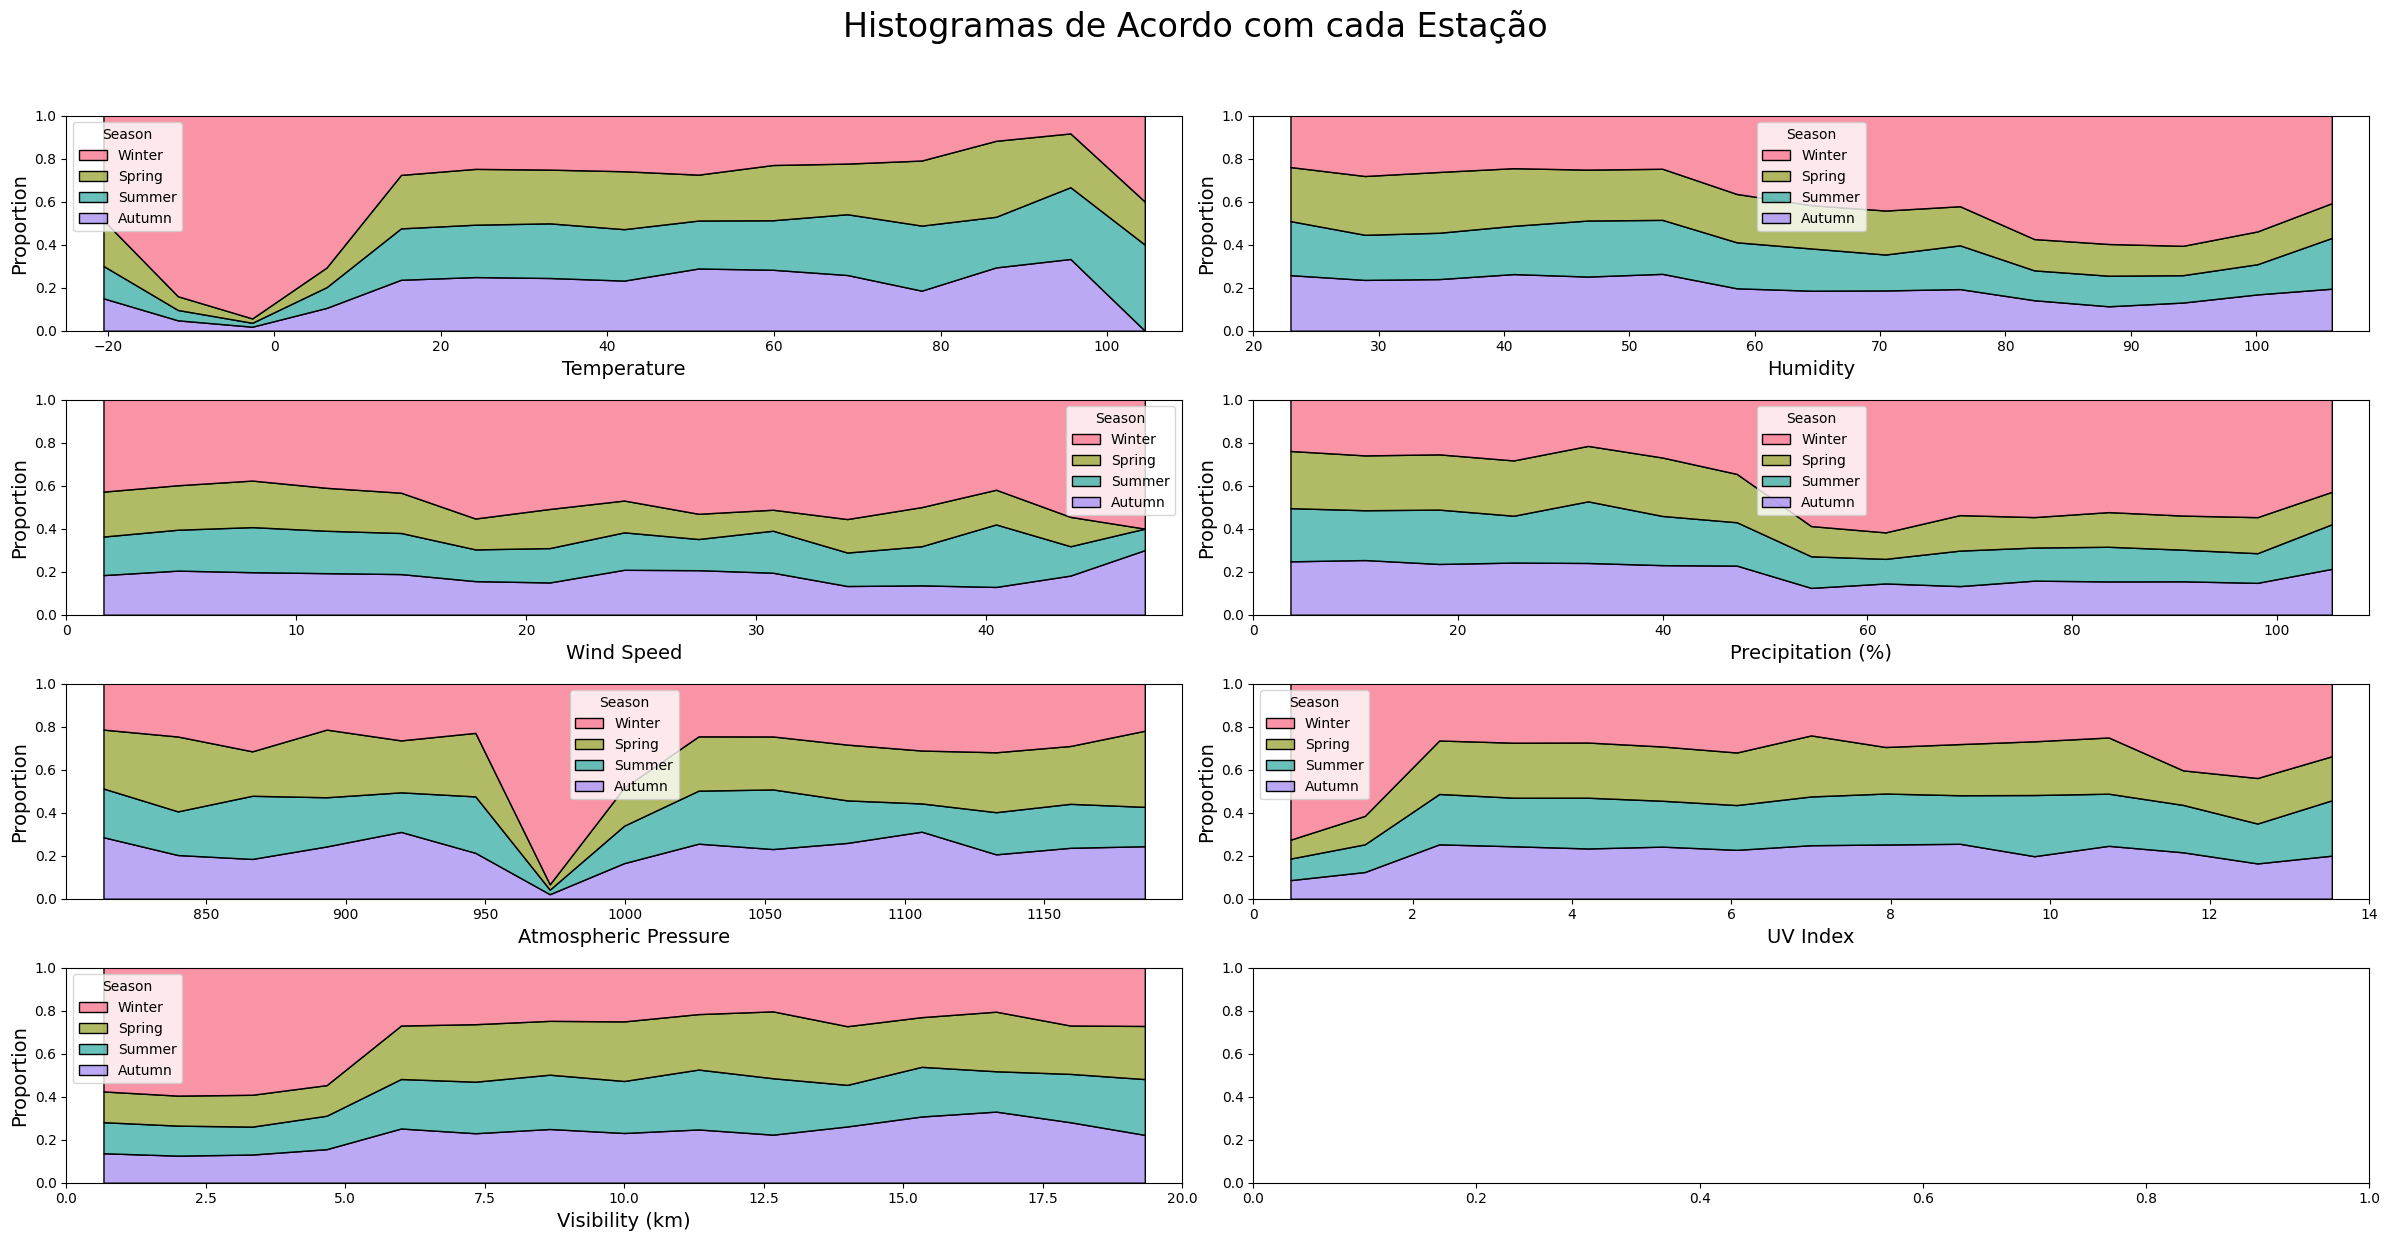

In [159]:
hist_plot_features = df_weather.drop(columns=['Cloud Cover', 'Season', 'Location', 'Weather Type']).columns.tolist()
hue = 'Season'

linha = 0
coluna = 0

fig, axes = plt.subplots(ncols=2, nrows=4)
fig.set_size_inches(24, 12)
fig.suptitle('Histogramas de Acordo com cada Estação', fontsize=24, y=1.03)

for ftr in hist_plot_features:
    ax = sns.histplot(data=df_weather, x=ftr, hue='Season', element='poly', multiple='fill', palette='husl', bins= 15,ax=axes[linha][coluna])
    ax.set_xlabel(ftr, fontsize=14)
    ax.set_ylabel('Proportion', fontsize=14)
    
    coluna += 1

    if coluna == 2:
        coluna = 0
        linha += 1

    plt.tight_layout()

plt.show()

### Conclusões do histograma

- Temperature (Temperatura): A temperatura mais alta está associada ao verão (Summer), e as mais baixas ocorrem no inverno (Winter). A primavera (Spring) e o outono (Autumn) aparecem como intermediários.

- Humidity (Umidade): As estações parecem seguir um padrão mais homogêneo, com um leve aumento de umidade durante o outono e inverno, e uma leve redução no verão.

- Wind Speed (Velocidade do Vento): Há um comportamento relativamente estável entre as estações, mas parece haver ventos ligeiramente mais fortes durante o inverno.

- Precipitation (%) (Precipitação): A precipitação parece ser mais frequente no inverno e outono, diminuindo na primavera e ainda mais no verão.

- Atmospheric Pressure (Pressão Atmosférica): A pressão parece variar mais significativamente durante o inverno e a primavera.

- UV Index (Índice UV): A intensidade do índice UV é muito maior no verão, sendo baixa nas outras estações.

- Visibility (km) (Visibilidade): A visibilidade parece ser mais baixa no inverno, aumentando gradualmente nas outras estações.

### Barras

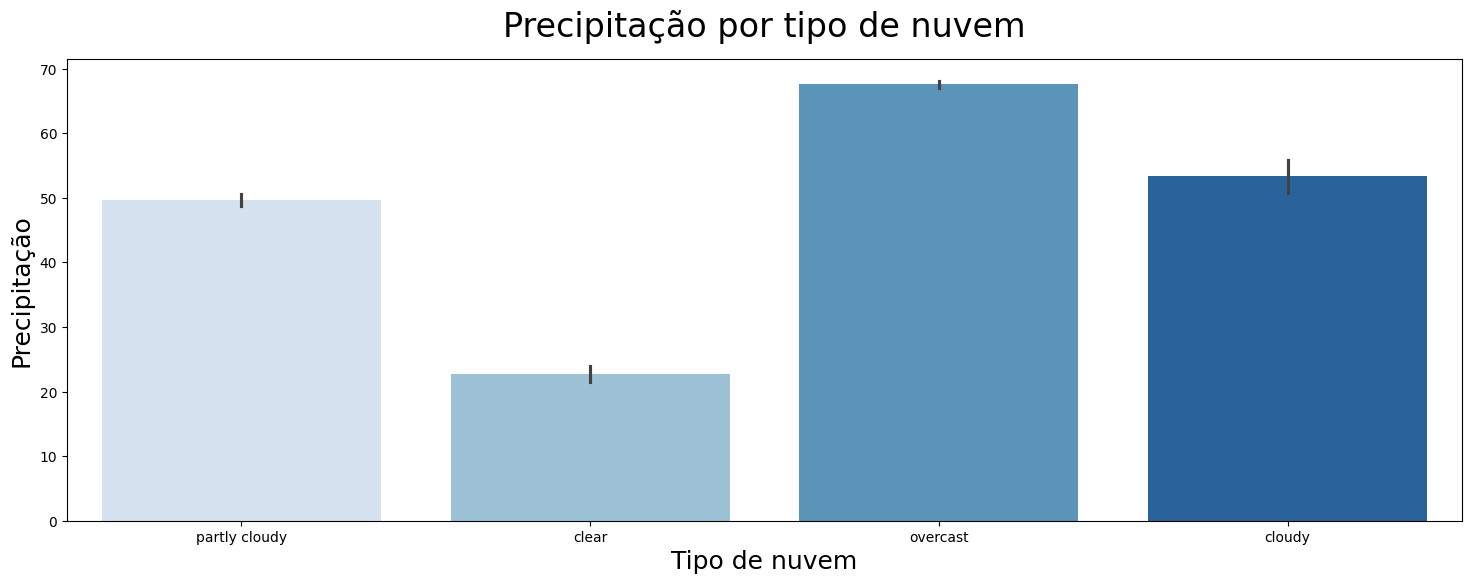

In [160]:
colors = sns.color_palette("Blues", n_colors=4)

ax = sns.barplot(data=df_weather, x='Cloud Cover', y='Precipitation (%)', palette=colors)
ax.figure.set_size_inches(18, 6)
ax.set_title('Precipitação por tipo de nuvem', fontsize=24, y=1.03)
ax.set_ylabel('Precipitação', fontsize=18)
ax.set_xlabel('Tipo de nuvem', fontsize=18)

plt.show()

## Modelo


### Separando o dataframe

In [161]:
features = df_weather.columns[0:10].tolist()
cat_features = ['Cloud Cover', 'Season', 'Location']
target = 'Weather Type'

X = df_weather[features]
y = df_weather[target]

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Analise

In [163]:
X_train.isna().sum()

Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
dtype: int64

In [164]:
y_train.isna().sum()

0

In [165]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,10560.0,19.324148,17.413081,-25.00,4.00,22.00,31.0000,109.00
Humidity,10560.0,68.625284,20.241225,20.00,57.00,70.00,84.0000,109.00
Wind Speed,10560.0,9.821875,6.903015,0.00,5.00,9.00,13.5000,48.50
Precipitation (%),10560.0,53.516477,31.944764,0.00,19.00,58.00,82.0000,109.00
Atmospheric Pressure,10560.0,1005.622655,37.260030,800.12,995.02,1007.73,1016.8025,1198.97
UV Index,10560.0,4.016383,3.854885,0.00,1.00,3.00,7.0000,14.00
Visibility (km),10560.0,5.466335,3.362760,0.00,3.00,5.00,7.5000,20.00


### Encoding

In [166]:
onehot_features = encoding.OneHotEncoder(variables=cat_features)

### preparando a target

In [167]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

### Modelo de aprendizagem

### RandomForestClassifier

In [168]:
model = RandomForestClassifier()

### Grid Search

In [169]:
params = {
    'min_samples_leaf': [10, 25, 50],
    'n_estimators': [50, 100, 250, 500,]
}

grid = GridSearchCV(model,
                    param_grid=params,
                    n_jobs=-1,
                    scoring='roc_auc_ovr',
                    cv=3)

### Pipeline

In [170]:
pipeline =  pipeline.Pipeline([
    ('onehot_features', onehot_features),
    ('grid', grid)
])

### Treino

In [171]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('onehot_features',
                 OneHotEncoder(variables=['Cloud Cover', 'Season',
                                          'Location'])),
                ('grid',
                 GridSearchCV(cv=3, estimator=RandomForestClassifier(),
                              n_jobs=-1,
                              param_grid={'min_samples_leaf': [10, 25, 50],
                                          'n_estimators': [50, 100, 250, 500]},
                              scoring='roc_auc_ovr'))])

In [172]:
predict_train = pipeline.predict(X_train)
predict_test = pipeline.predict(X_test)

proba_train = pipeline.predict_proba(X_train)
proba_test = pipeline.predict_proba(X_test)

### Métricas

In [173]:
acc_train = metrics.accuracy_score(y_train, predict_train)
acc_test  = metrics.accuracy_score(y_test, predict_test)

auc_train = metrics.roc_auc_score(y_train, proba_train, multi_class='ovr')
auc_test = metrics.roc_auc_score(y_test, proba_test, multi_class='ovr')

kappa_train = metrics.cohen_kappa_score(y_train, predict_train)
kappa_test = metrics.cohen_kappa_score(y_test, predict_test)

precision_train = metrics.precision_score(y_train, predict_train, average='macro')
precision_test = metrics.precision_score(y_test, predict_test, average='macro')

recall_train = metrics.recall_score(y_train, predict_train, average='macro') 
recall_test = metrics.recall_score(y_test, predict_test, average='macro') 

print(f'Acuracia base train: {round(acc_train * 100, 2)}%')
print(f'Acuracia base test: {round(acc_test * 100, 2)}%')
print()
print(f'Kappa_score base train: {round(kappa_train * 100, 2)}%') 
print(f'Kappa_score base test: {round(kappa_test * 100, 2)}%')
print()
print(f'AUC base train: {round(auc_train * 100, 2)}%')
print(f'AUC base test: {round(auc_test * 100, 2)}%')
print()
print(f'Precision base train: {round(precision_train * 100, 2)}%')
print(f'Precision base test: {round(precision_test * 100, 2)}%')
print()
print(f'Recall base train: {round(recall_train * 100, 2)}%')
print(f'Recall base test: {round(recall_test * 100, 2)}%')

Acuracia base train: 95.73%
Acuracia base test: 91.33%

Kappa_score base train: 94.31%
Kappa_score base test: 88.43%

AUC base train: 99.78%
AUC base test: 99.26%

Precision base train: 95.78%
Precision base test: 91.36%

Recall base train: 95.73%
Recall base test: 91.26%


### Graficos do modelo

Text(0.5, 1.03, 'Matriz de correlação')

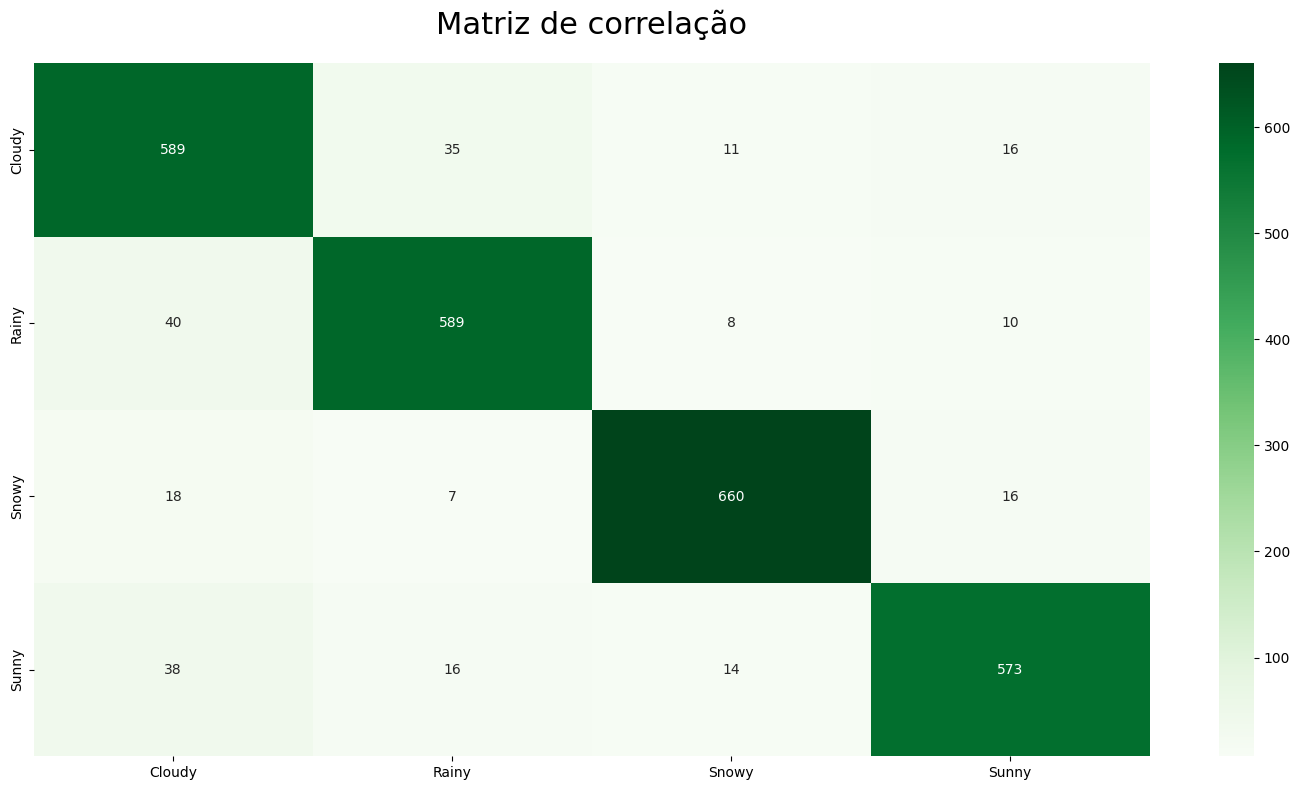

In [174]:
confusion_matrix = metrics.confusion_matrix(y_test, predict_test)
class_labels = label_encoder.classes_

confusion_matrix = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

ax = sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Greens')
ax.figure.set_size_inches(18, 9)
ax.set_title('Matriz de correlação', fontsize=22, y=1.03)

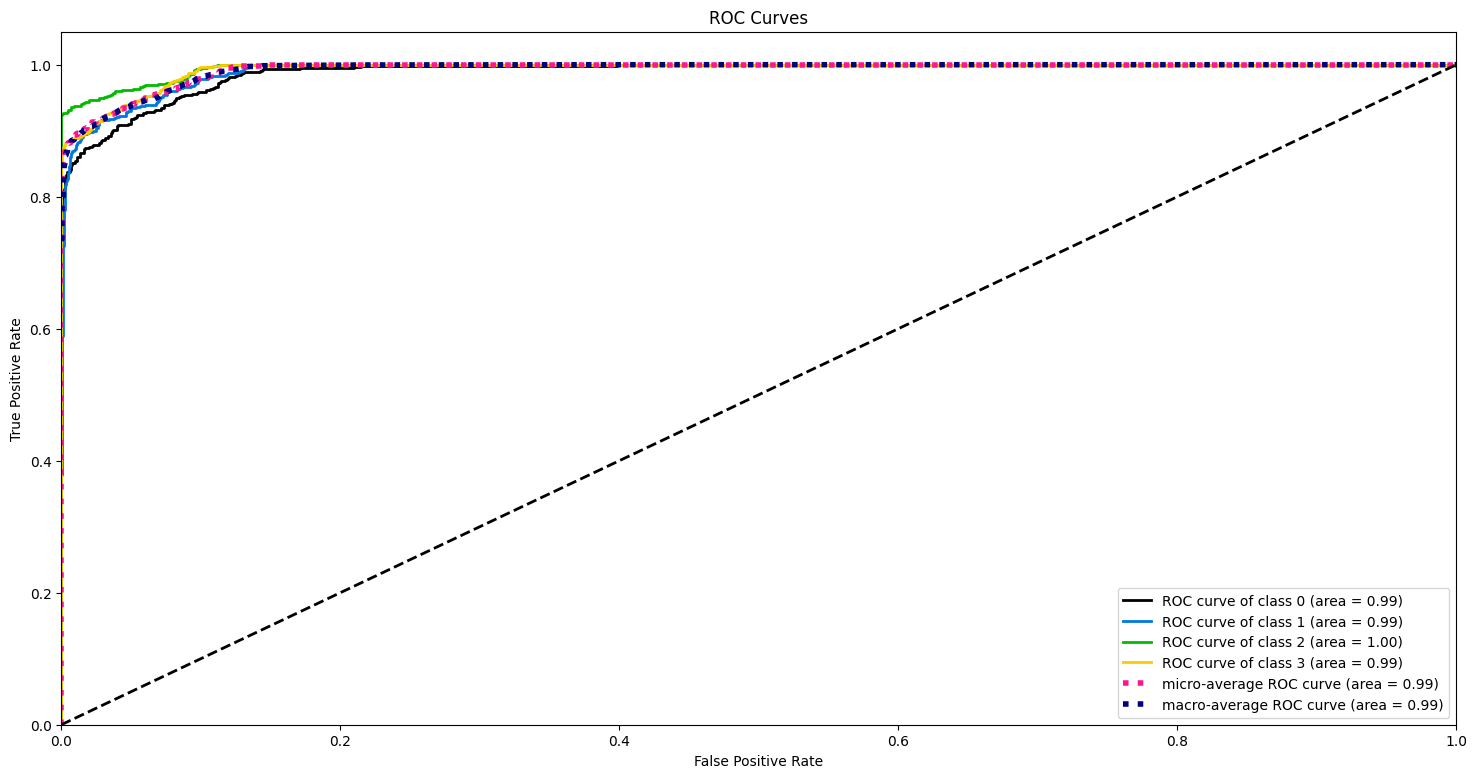

In [175]:
ax = skplt.metrics.plot_roc(y_test, proba_test)
ax.figure.set_size_inches(18, 9)
plt.show()

### KNeighborsClassifier

In [176]:
model = KNeighborsClassifier()

In [177]:
params = {
    'n_neighbors': [5, 10, 15, 20],
    'leaf_size': [30, 35, 40, 50, 55, 60, 65, 70, 75, 80]
}

grid = GridSearchCV(model,
                    param_grid=params,
                    n_jobs=-1,
                    scoring='roc_auc_ovr',
                    cv=3)

### Pipeline

In [180]:
pipeline = pipeline.Pipeline([
    ('onehot', onehot_features),
    ('grid', grid)
])

### Treino

In [181]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('onehot',
                 OneHotEncoder(variables=['Cloud Cover', 'Season',
                                          'Location'])),
                ('grid',
                 GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
                              param_grid={'leaf_size': [30, 35, 40, 50, 55, 60,
                                                        65, 70, 75, 80],
                                          'n_neighbors': [5, 10, 15, 20]},
                              scoring='roc_auc_ovr'))])

In [182]:
predict_train = pipeline.predict(X_train)
predict_test = pipeline.predict(X_test)

proba_train = pipeline.predict_proba(X_train)
proba_test = pipeline.predict_proba(X_test)

### Métricas

In [183]:
acc_train = metrics.accuracy_score(y_train, predict_train)
acc_test  = metrics.accuracy_score(y_test, predict_test)

auc_train = metrics.roc_auc_score(y_train, proba_train, multi_class='ovr')
auc_test = metrics.roc_auc_score(y_test, proba_test, multi_class='ovr')

kappa_train = metrics.cohen_kappa_score(y_train, predict_train)
kappa_test = metrics.cohen_kappa_score(y_test, predict_test)

precision_train = metrics.precision_score(y_train, predict_train, average='macro')
precision_test = metrics.precision_score(y_test, predict_test, average='macro')

recall_train = metrics.recall_score(y_train, predict_train, average='macro') 
recall_test = metrics.recall_score(y_test, predict_test, average='macro') 

print(f'Acuracia base train: {round(acc_train * 100, 2)}%')
print(f'Acuracia base test: {round(acc_test * 100, 2)}%')
print()
print(f'Kappa_score base train: {round(kappa_train * 100, 2)}%') 
print(f'Kappa_score base test: {round(kappa_test * 100, 2)}%')
print()
print(f'AUC base train: {round(auc_train * 100, 2)}%')
print(f'AUC base test: {round(auc_test * 100, 2)}%')
print()
print(f'Precision base train: {round(precision_train * 100, 2)}%')
print(f'Precision base test: {round(precision_test * 100, 2)}%')
print()
print(f'Recall base train: {round(recall_train * 100, 2)}%')
print(f'Recall base test: {round(recall_test * 100, 2)}%')

Acuracia base train: 90.06%
Acuracia base test: 88.45%

Kappa_score base train: 86.74%
Kappa_score base test: 84.59%

AUC base train: 99.05%
AUC base test: 98.3%

Precision base train: 90.22%
Precision base test: 88.49%

Recall base train: 90.08%
Recall base test: 88.32%


### Graficos do modelo

Text(0.5, 1.03, 'Matriz de correlação')

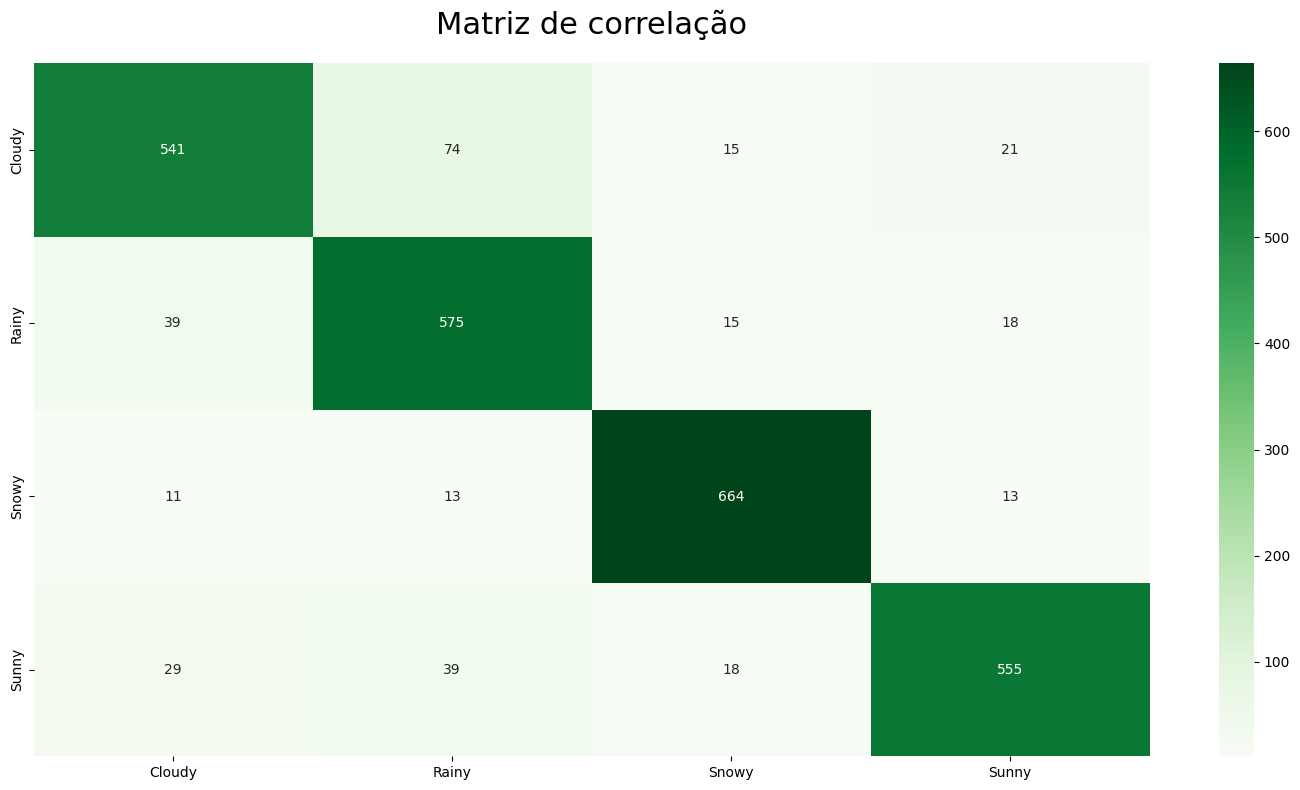

In [184]:
confusion_matrix = metrics.confusion_matrix(y_test, predict_test)
class_labels = label_encoder.classes_

confusion_matrix = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

ax = sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Greens')
ax.figure.set_size_inches(18, 9)
ax.set_title('Matriz de correlação', fontsize=22, y=1.03)

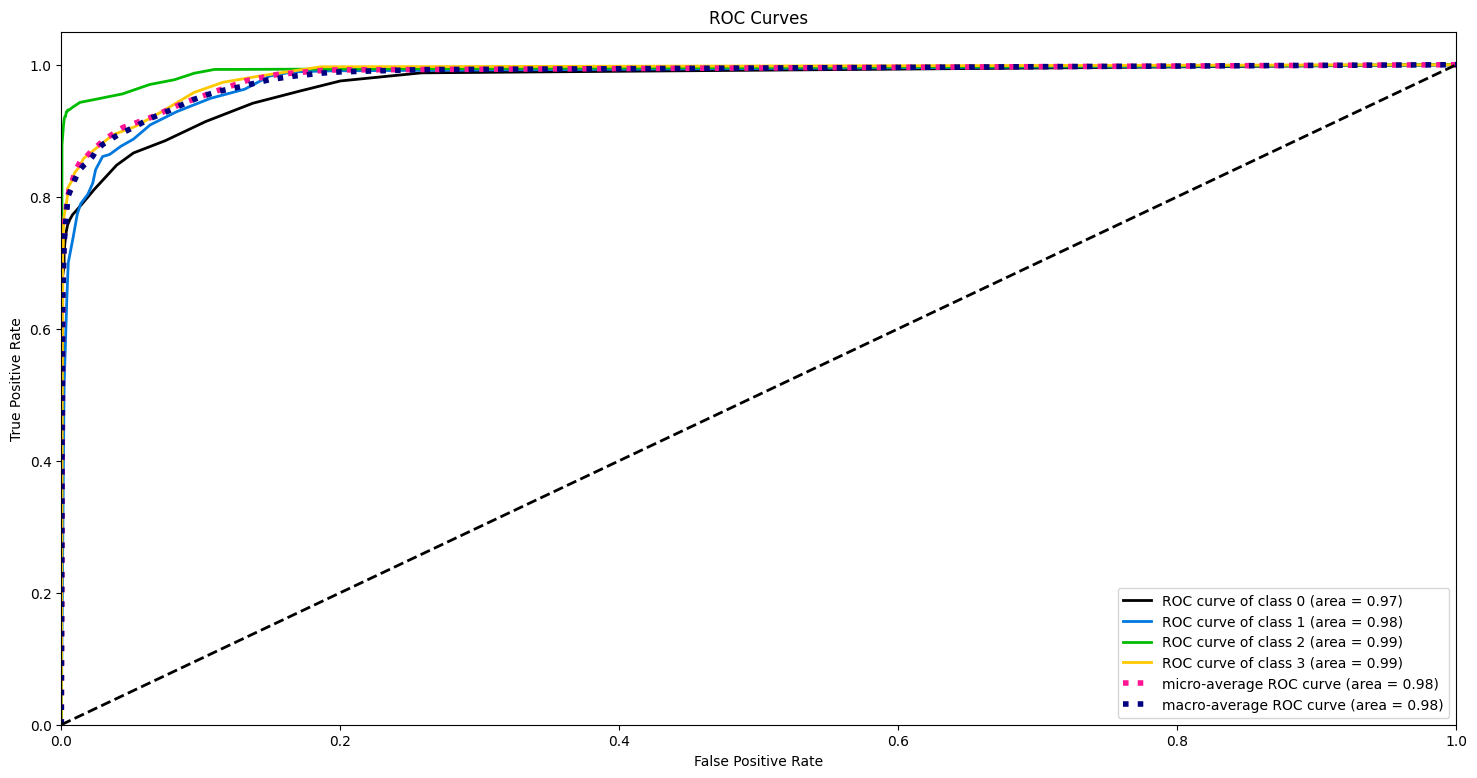

In [185]:
ax = skplt.metrics.plot_roc(y_test, proba_test)
ax.figure.set_size_inches(18, 9)
plt.show()

### Xgboost

In [326]:
xgb = XGBClassifier(objective='multi: softmax', subsample=0.85, colsample_bytree=0.8, gamma=0, learning_rating=0.01)

### Grid Search


In [327]:
paramns = {
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 5, 10],
    'n_estimators': [80, 81, 82, 83, 84, 85],
    'max_depth': [2, 3],
    'min_child_weigh': [6, 7]
}

grid = GridSearchCV(xgb,
                    param_grid=paramns,
                    n_jobs=-1,
                    scoring='roc_auc_ovr',
                    cv=3)

### Pipeline

In [328]:
pipeline = pipeline.Pipeline([
    ('onehot', onehot_features),
    ('grid', grid)
])

### Treino

In [329]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('onehot',
                 OneHotEncoder(variables=['Cloud Cover', 'Season',
                                          'Location'])),
                ('grid',
                 GridSearchCV(cv=3,
                              estimator=XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.8,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gam...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...),
                              n_jobs=-1,
                              param_grid={'max_depth': [2, 3],
                                          'min_child_weigh': [6, 7],
                                          'n_estimators': [80, 81, 82, 83, 84,
                                                           85],
                                          'reg_alpha': [0, 0.01, 0.1],
                                          'reg_lambda': [1, 5, 10]},
                              scoring='roc_auc_ovr'))])

In [330]:
predict_train = pipeline.predict(X_train)
predict_test = pipeline.predict(X_test)

proba_train = pipeline.predict_proba(X_train)
proba_test = pipeline.predict_proba(X_test)

### Métricas

In [331]:
acc_train = metrics.accuracy_score(y_train, predict_train)
acc_test  = metrics.accuracy_score(y_test, predict_test)

auc_train = metrics.roc_auc_score(y_train, proba_train, multi_class='ovr')
auc_test = metrics.roc_auc_score(y_test, proba_test, multi_class='ovr')

kappa_train = metrics.cohen_kappa_score(y_train, predict_train)
kappa_test = metrics.cohen_kappa_score(y_test, predict_test)

precision_train = metrics.precision_score(y_train, predict_train, average='macro')
precision_test = metrics.precision_score(y_test, predict_test, average='macro')

recall_train = metrics.recall_score(y_train, predict_train, average='macro') 
recall_test = metrics.recall_score(y_test, predict_test, average='macro') 

print(f'Acuracia base train: {round(acc_train * 100, 2)}%')
print(f'Acuracia base test: {round(acc_test * 100, 2)}%')
print()
print(f'Kappa_score base train: {round(kappa_train * 100, 2)}%') 
print(f'Kappa_score base test: {round(kappa_test * 100, 2)}%')
print()
print(f'AUC base train: {round(auc_train * 100, 2)}%')
print(f'AUC base test: {round(auc_test * 100, 2)}%')
print()
print(f'Precision base train: {round(precision_train * 100, 2)}%')
print(f'Precision base test: {round(precision_test * 100, 2)}%')
print()
print(f'Recall base train: {round(recall_train * 100, 2)}%')
print(f'Recall base test: {round(recall_test * 100, 2)}%')

Acuracia base train: 95.08%
Acuracia base test: 91.14%

Kappa_score base train: 93.43%
Kappa_score base test: 88.17%

AUC base train: 99.72%
AUC base test: 99.24%

Precision base train: 95.09%
Precision base test: 91.11%

Recall base train: 95.08%
Recall base test: 91.05%


### Graficos do modelo

Text(0.5, 1.03, 'Matriz de correlação')

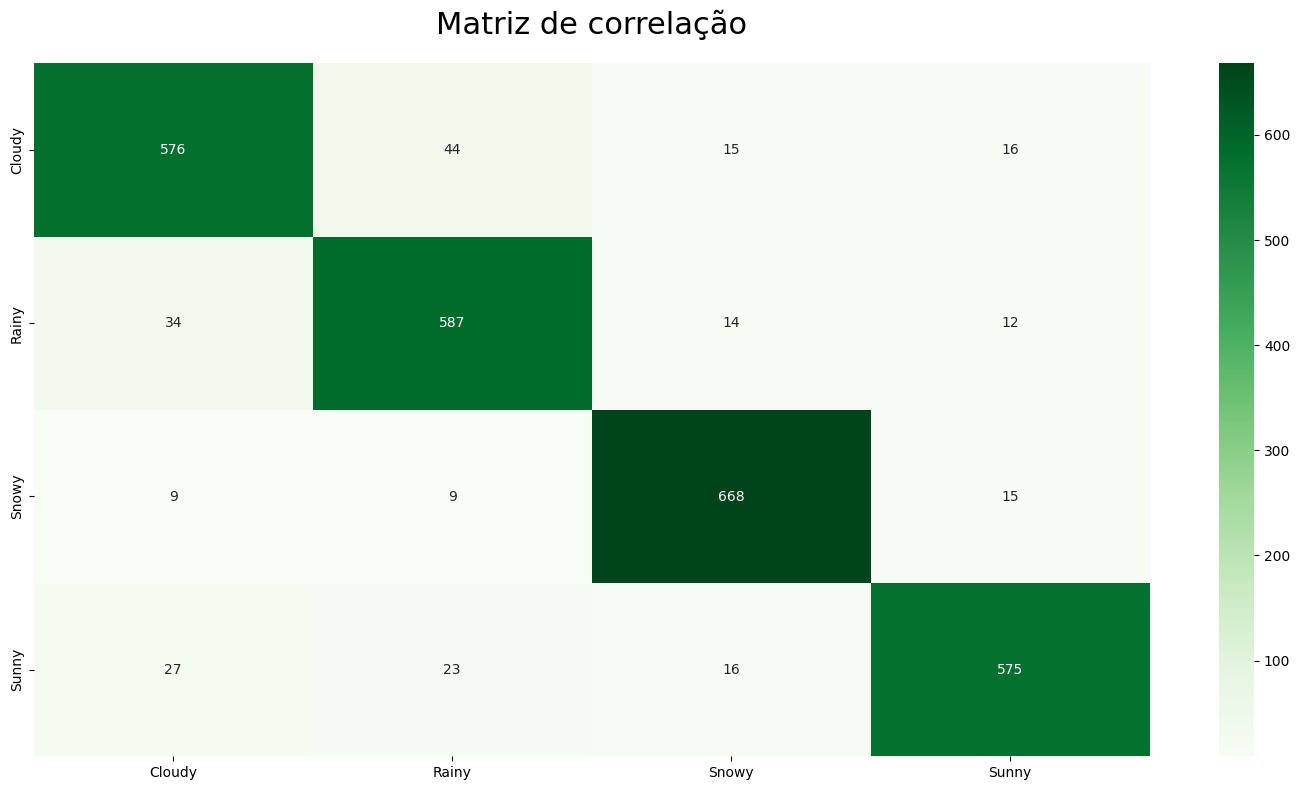

In [332]:
confusion_matrix = metrics.confusion_matrix(y_test, predict_test)
class_labels = label_encoder.classes_

confusion_matrix = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

ax = sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Greens')
ax.figure.set_size_inches(18, 9)
ax.set_title('Matriz de correlação', fontsize=22, y=1.03)

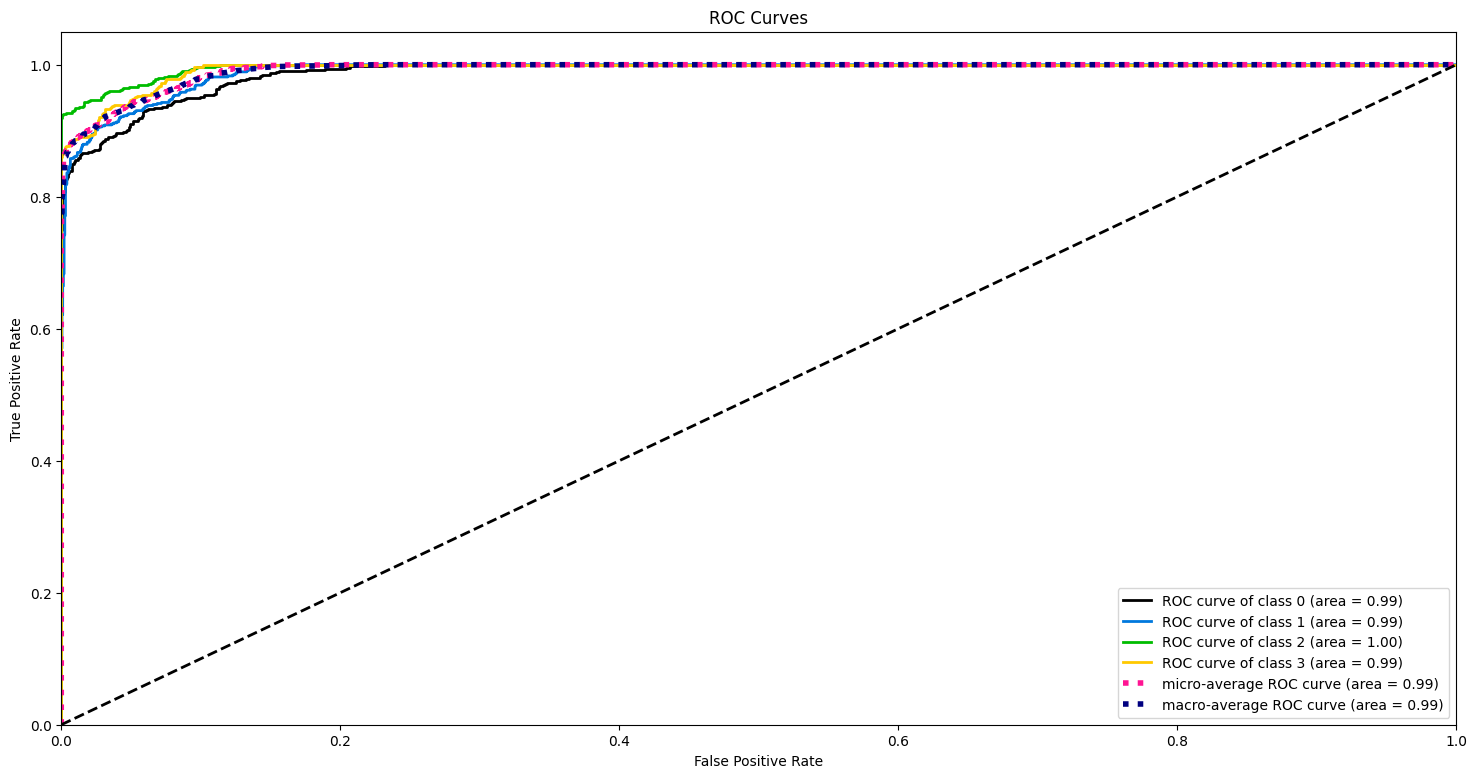

In [333]:
ax = skplt.metrics.plot_roc(y_test, proba_test)
ax.figure.set_size_inches(18, 9)
plt.show()

Conclusão dos modelos
- RandomForestClassifier e XGBClassifierteve tiveram um desempenho parecido na curva roc que é uma métrica mais segura já que é uma métrica probabilística e foi a métrica utilizada para avaliar os modelos.